In [110]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap
import matplotlib.pyplot as plt

In [111]:
group1 = pd.read_csv('DataPaper/group1.csv')

In [112]:
group1 = group1.drop(['time_seconds', 'time_radians','STAI1','STAI2','day','hour','ibi_s'],axis=1).dropna()
group1 = group1.sample(frac=1).reset_index(drop=True)

In [113]:
group1 = group1.groupby('user').head(150)

In [114]:
high_state_anxiety = group1[group1['class'] == 'high_state_anxiety']
low_state_anxiety = group1[group1['class'] == 'low_state_anxiety']

high_state_anxiety_users = high_state_anxiety['user'].unique()
low_state_anxiety_users = low_state_anxiety['user'].unique()

In [115]:
min_users = min(len(high_state_anxiety_users), len(low_state_anxiety_users))

In [116]:
high_state_anxiety_users_selected = pd.Series(
    high_state_anxiety_users).sample(n=min_users, random_state=42).values
low_state_anxiety_users_selected = pd.Series(
    low_state_anxiety_users).sample(n=min_users, random_state=42).values

In [117]:
high_state_anxiety_selected = high_state_anxiety[high_state_anxiety['user'].isin(
    high_state_anxiety_users_selected)]
low_state_anxiety_selected = low_state_anxiety[low_state_anxiety['user'].isin(
    low_state_anxiety_users_selected)]

In [118]:
balanced_data = pd.concat(
    [high_state_anxiety_selected, low_state_anxiety_selected])
balanced_data = balanced_data.sample(
    frac=1, random_state=42).reset_index(drop=True)

In [119]:
X = balanced_data.drop(columns=['class', 'user'])
y = balanced_data['class']

In [120]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [121]:
for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

train_data = X_train.copy()
train_data['class'] = y_train
test_data = X_test.copy()
test_data['class'] = y_test

In [122]:
label = LabelEncoder()
y_train_encoded = label.fit_transform(y_train)
y_test_encoded = label.transform(y_test)

In [123]:
print(f"Training set class distribution:\n{y_train.value_counts()}")
print(f"Test set class distribution:\n{y_test.value_counts()}")

Training set class distribution:
class
high_state_anxiety    720
low_state_anxiety     720
Name: count, dtype: int64
Test set class distribution:
class
low_state_anxiety     180
high_state_anxiety    180
Name: count, dtype: int64


In [124]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

In [125]:
pipelines = {}
shap_values_dict = {}
explainers = {}

In [126]:
for model_name, model in models.items():
    pipelines[model_name] = Pipeline([
        ('classifier', model)
    ])
    print(f"Training {model_name}...")
    pipelines[model_name].fit(X_train, y_train_encoded)

    if model_name == 'XGBoost':
        explainer = shap.Explainer(
            pipelines[model_name].named_steps['classifier'])
    else:
        explainer = shap.TreeExplainer(
            pipelines[model_name].named_steps['classifier'])

    explainers[model_name] = explainer
    shap_values = explainer.shap_values(X_test)
    shap_values_dict[model_name] = shap_values

Training RandomForest...
Training XGBoost...
Training DecisionTree...


In [127]:
results = {}
for model_name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_test)
    results[model_name] = {
        'classification_report': classification_report(y_test_encoded, y_pred),
        'confusion_matrix': confusion_matrix(y_test_encoded, y_pred),
        'accuracy_score': accuracy_score(y_test_encoded, y_pred)
    }

In [128]:
for model_name, metrics in results.items():
    print(f"Results for {model_name}:\n")
    print(f"Classification Report:\n{metrics['classification_report']}\n")
    print(f"Confusion Matrix:\n{metrics['confusion_matrix']}\n")
    print(f"Accuracy Score: {metrics['accuracy_score']}\n")

Results for RandomForest:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       180
           1       1.00      1.00      1.00       180

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360


Confusion Matrix:
[[180   0]
 [  0 180]]

Accuracy Score: 1.0

Results for XGBoost:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       180
           1       1.00      1.00      1.00       180

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360


Confusion Matrix:
[[180   0]
 [  0 180]]

Accuracy Score: 1.0

Results for DecisionTree:

Classification Report:
              precision    recall  f1-score   support

           0      

SHAP Summary for RandomForest:


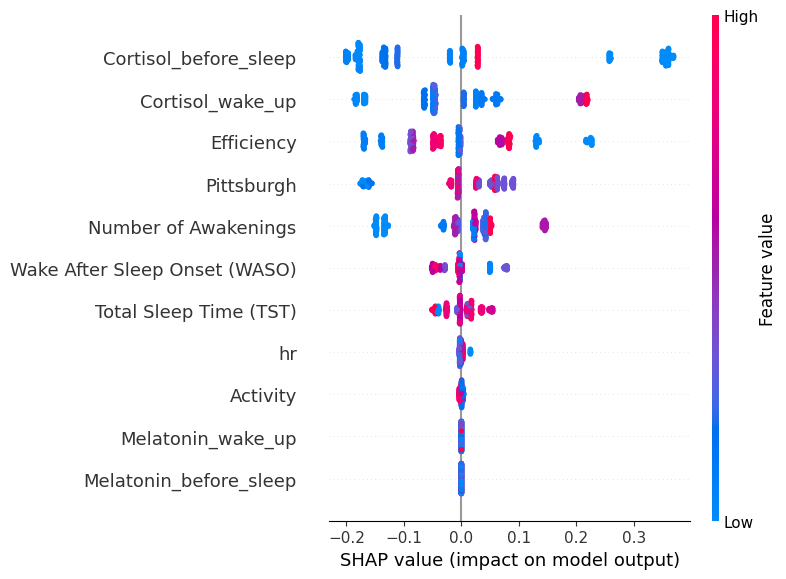

SHAP Summary for XGBoost:


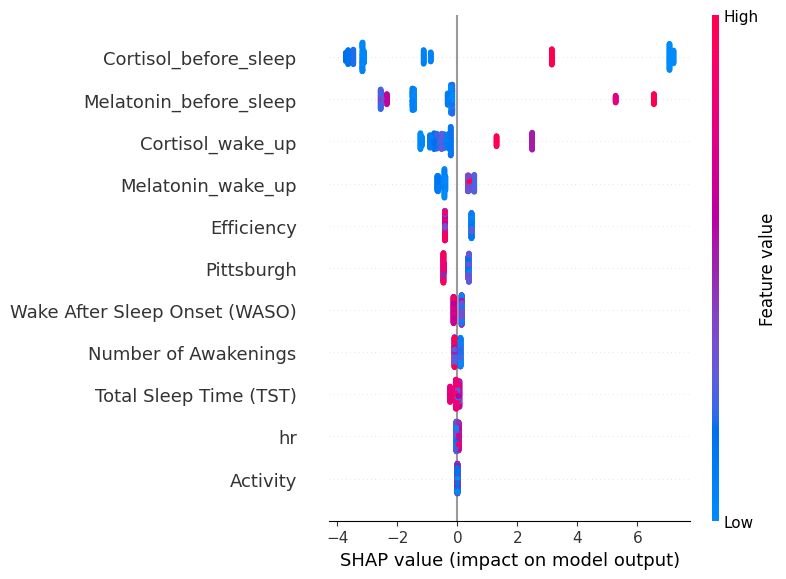

SHAP Summary for DecisionTree:


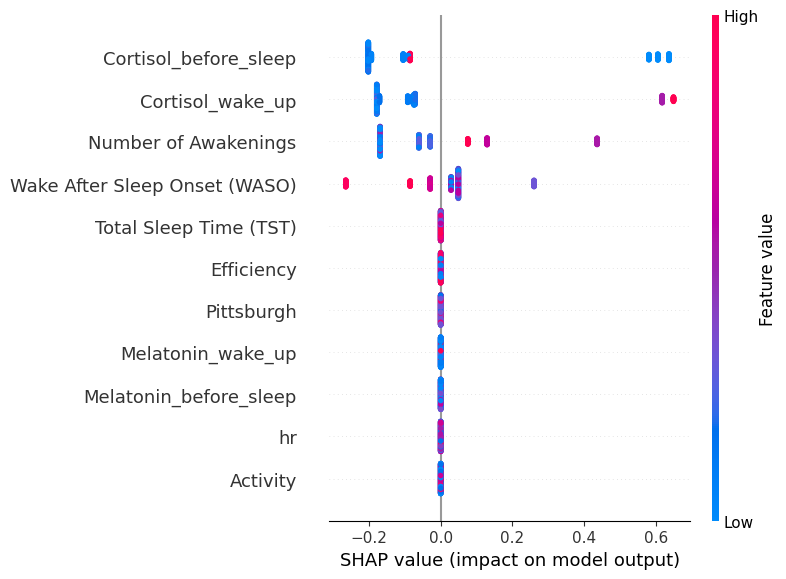

In [129]:
for model_name, shap_values in shap_values_dict.items():
    print(f"SHAP Summary for {model_name}:")
    if model_name == 'XGBoost':
        shap.summary_plot(shap_values, X_test)
    else:
        shap.summary_plot(shap_values[1], X_test)

SHAP Summary for RandomForest:


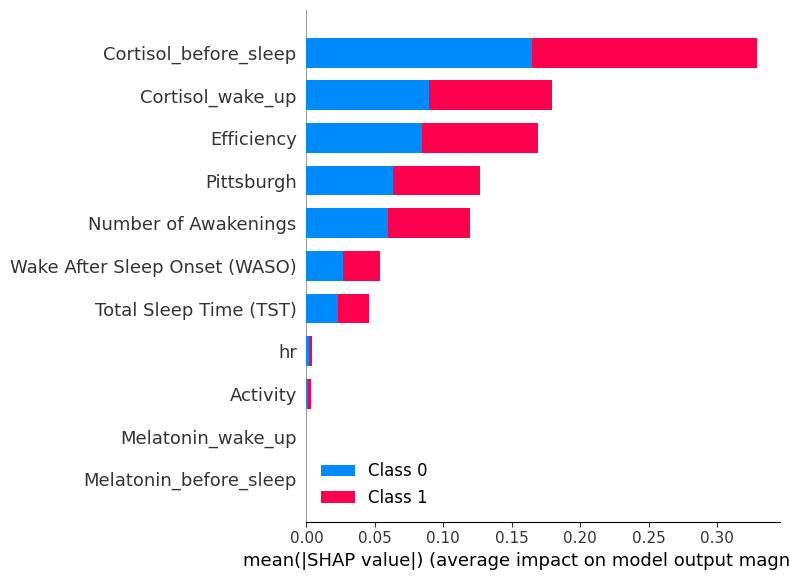

SHAP Summary for XGBoost:


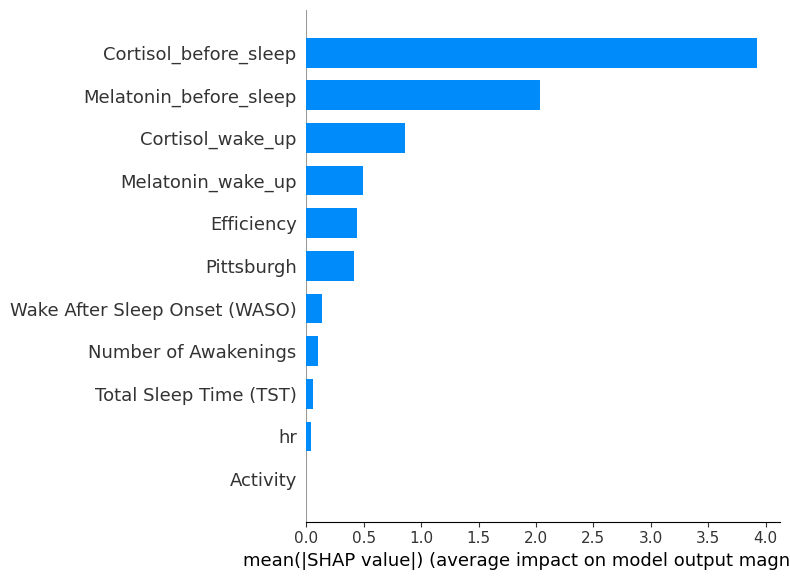

SHAP Summary for DecisionTree:


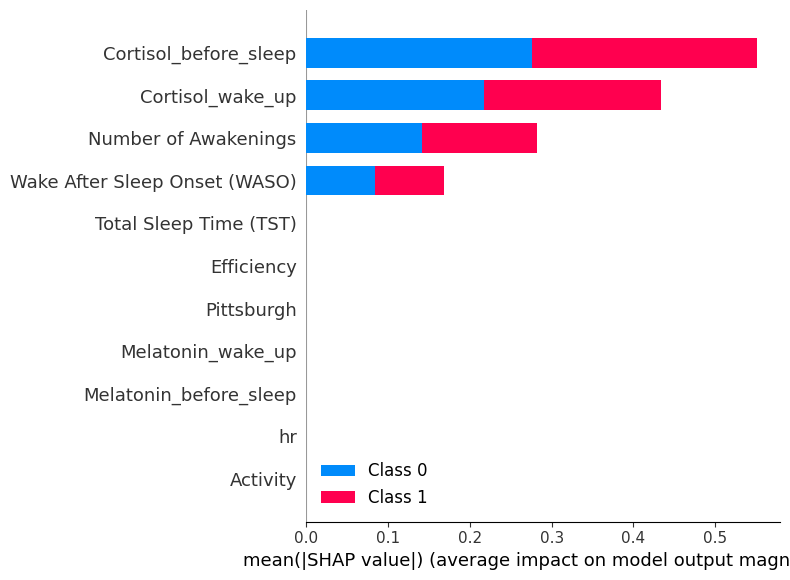

In [130]:
for model_name, shap_values in shap_values_dict.items():
    print(f"SHAP Summary for {model_name}:")
    shap.summary_plot(shap_values, X_test, plot_type='bar')